# 1o Estágio: Recorte das dorsais de baleia e Golfinhos utilizando Yolo

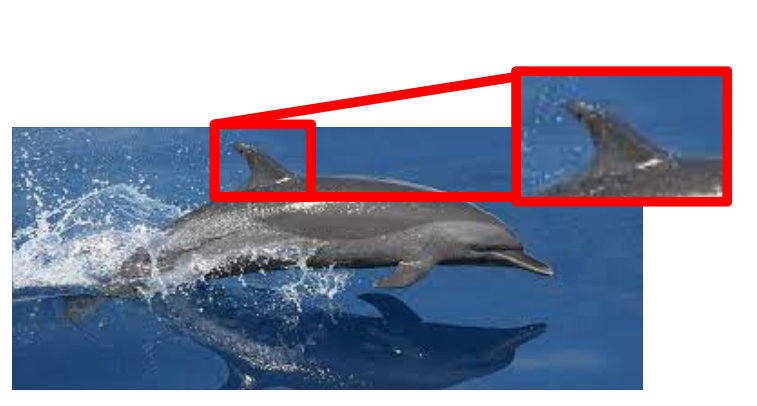




## Objetivo

Este notebook tem por objetivo treinar o primeiro estágio do pipeline, que consiste na extração de dorsais de baleias e golfinhos. Para isso utilizaremos o algoritmo Yolo.

`INSTITUIÇÃO: PONTIFÍCIA UNIVERSIDADE CATÓLICA DE MINAS GERAIS`

`CURSO: PÓS-GRADUAÇÃO LATO SENSU EM INTELIGÊNCIA ARTIFICAL E APRENDIZADO DE MÁQUINA`

`ALUNO: ROBSON TADEU DA CRUZ SANTOS`

`PROJETO: IDENTIFICAÇÃO DE BALEIAS E GOLFINHOS ATRAVÉS DE SUAS CARACTERÍSTICAS`

O projeto tem por objetivo final criar solução de aprendizado de máquina para identificar a identidade de baleias e golfinhos a partir de imagens. O foco deste notebook será de realizar análise exploratória.

# Instalação 🛠 

In [1]:
!pip install -qU bbox-utility
!pip install -q imagesize
!pip install -qU wandb

     |████████████████████████████████| 58 kB 5.2 MB/s 
     |████████████████████████████████| 1.8 MB 14.1 MB/s 
     |████████████████████████████████| 181 kB 83.0 MB/s 
     |████████████████████████████████| 157 kB 63.4 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
     |████████████████████████████████| 157 kB 79.0 MB/s 
     |████████████████████████████████| 157 kB 89.3 MB/s 
     |████████████████████████████████| 157 kB 94.7 MB/s 
     |████████████████████████████████| 156 kB 96.3 MB/s 


## Importando Bibliotecas 📚 

In [2]:
import os
import numpy as np
import random
import torch
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import glob
import imagesize
import shutil
from tqdm.notebook import tqdm
from sklearn.model_selection import KFold

# funcoes para conversão de formato de bounding boxes
from bbox.utils import coco2yolo, coco2voc, voc2yolo, yolo2voc
from bbox.utils import draw_bboxes, load_image
from bbox.utils import clip_bbox, str2annot, annot2str

import yaml
import wandb

tqdm.pandas()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
wandb.init()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Configuração 📈

In [5]:
class CFG:
    seed        = 2022
    root_dir    = '/content/drive/MyDrive/Competicoes/pos_puc/'
    fold        = 0
    img_size    = 512
    batch_size  = 16
    model       = 'yolov5x'
    epochs      = 16
    optimizer   = 'SGD'
    img_dir     = '/content/dataset/images'
    ann_dir     = '/content/dataset/labels'
    project     = "happywhale-pos-puc"  # nome do projeto no weights and biases
    name        = f"{model}-dim{img_size}-fold{fold}"  # nome da corrida no weights and biases

## Carregando Arquivos ✏️ 

In [6]:
os.makedirs('./dataset', exist_ok=True)
os.makedirs('./dataset/labels', exist_ok=True)

!cp {CFG.root_dir}/whale-categorization-playground.zip ./dataset
!cp {CFG.root_dir}/cropping.txt .
!unzip -q ./dataset/whale-categorization-playground.zip -d ./dataset/
!mv /content/dataset/train {CFG.img_dir}

## Utils 🔨

In [7]:
# funcao para obter bounding boxes de anotacoes
def get_bbox(annotations):
    bboxes = [list(annotation.values()) for annotation in annotations]
    return bboxes


# funcao para obter dimensoes de uma imagem
def get_image_size(row):
    row['width'], row['height'] = imagesize.get(row['img_path'])
    return row


# criar bounding boxes
def points_2_bbox(points):
    points = np.array(points)
    points = points.astype('int')
    points = points.reshape(-1, 2)
    xmin, ymin, xmax, ymax = points[:, 0].min(), points[:, 1].min(), points[:, 0].max(), points[:, 1].max()
    return [[xmin, ymin, xmax, ymax]]


# para reproducibilidade
def set_seed(seed=42):
  '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
  np.random.seed(seed)
  random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  # When running on the CuDNN backend, two further options must be set
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  # Set a fixed value for the hash seed
  os.environ['PYTHONHASHSEED'] = str(seed)
  print('> SEEDING DONE')


set_seed(CFG.seed)
colors = [(np.random.randint(255), np.random.randint(255), np.random.randint(255))\
          for idx in range(1)]

> SEEDING DONE


## Preprocessamento ✏️

In [8]:
df = pd.read_csv('./dataset/train.csv')
df['img_path'] = df['Image'].apply(lambda x: f'{CFG.img_dir}/{x}')
df['label_path'] = df['Image'].apply(lambda x: f'{CFG.ann_dir}/{x}'.replace('jpg', 'txt'))

with open('cropping.txt', 'rt') as file_:
    text = file_.read()
    id2point = {row.split(',')[0]: row.split(',')[1:] for row in text.split('\n')}

df['point'] = df['Image'].map(id2point)
df = df[~df['point'].isna()]
df['bbox'] = df.point.map(points_2_bbox)
df = df.progress_apply(get_image_size, axis=1)

df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/1200 [00:00<?, ?it/s]

Image         Id                              img_path  \
1  000466c4.jpg  w_1287fbc  /content/dataset/images/000466c4.jpg   
2  00087b01.jpg  w_da2efe0  /content/dataset/images/00087b01.jpg   
4  0014cfdf.jpg  w_f22f3e3  /content/dataset/images/0014cfdf.jpg   
5  0025e8c2.jpg  w_8b1ca89  /content/dataset/images/0025e8c2.jpg   
7  0031c258.jpg  new_whale  /content/dataset/images/0031c258.jpg   

                             label_path  \
1  /content/dataset/labels/000466c4.txt   
2  /content/dataset/labels/00087b01.txt   
4  /content/dataset/labels/0014cfdf.txt   
5  /content/dataset/labels/0025e8c2.txt   
7  /content/dataset/labels/0031c258.txt   

                                               point                    bbox  \
1  [233, 308, 243, 301, 508, 307, 578, 391, 561, ...  [[233, 301, 578, 434]]   
2  [1, 63, 80, 8, 1010, 20, 1040, 28, 473, 365, 3...     [[1, 8, 1040, 366]]   
4  [43, 180, 50, 165, 630, 117, 648, 140, 473, 29...   [[43, 117, 648, 306]]   
5  [118, 240, 142, 216, 847, 213, 874, 251, 676, ...  [[118, 213, 874, 409]]   
7  [2, 29, 995, 14, 1037, 98, 694, 415, 457, 436,...    [[2, 14, 1037, 436]]   

   width  height  
1   1050     700  
2   1050     368  
4    700     398  
5   1000     652  
7   1050     456

### Criando Labels

In [9]:
cnt = 0
all_bboxes = []
bboxes_info = []
for row_idx in tqdm(range(df.shape[0])):
    row = df.iloc[row_idx]
    image_height = row.height
    image_width = row.width
    bboxes_voc = np.array(row.bbox).astype(np.float32).copy()
    num_bbox = len(bboxes_voc)
    names = ["whale"] * num_bbox
    labels = np.array([0] * num_bbox)[..., None].astype(str)
    
    with open(row.label_path, "w") as f:
        if num_bbox < 1:
            annot = ""
            f.write(annot)
            cnt += 1
            continue
    
        bboxes_voc = clip_bbox(bboxes_voc, image_height, image_width)
        bboxes_yolo = voc2yolo(bboxes_voc, image_height, image_width).astype(str)
        all_bboxes.extend(bboxes_yolo.astype(float))
        bboxes_info.extend([[row.Image]] * len(bboxes_yolo))
        annots = np.concatenate([labels, bboxes_yolo], axis=1)
        string = annot2str(annots)
        f.write(string)

print("Perdidos:", cnt)


  0%|          | 0/1200 [00:00<?, ?it/s]

Perdidos: 0


## Criando Folds 📁

In [10]:
kf = KFold(n_splits=6, random_state=42, shuffle=True)
df = df.reset_index(drop=True)
df['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(kf.split(df)):
    df.loc[val_idx, 'fold'] = fold
    
df['fold'].value_counts()

2    200
5    200
1    200
4    200
0    200
3    200
Name: fold, dtype: int64

## Visualização

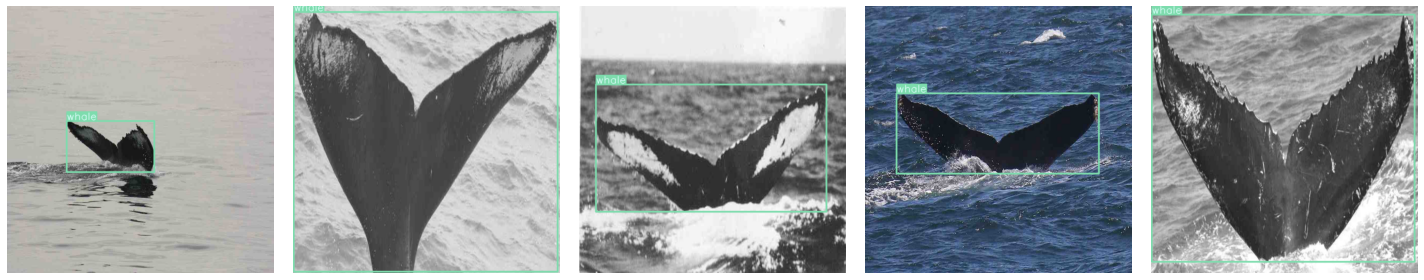

In [11]:
df_sample = df.iloc[:5]

y=1
x=5

plt.figure(figsize=(20, 4))
for idx in range(x*y):
    row = df_sample.iloc[idx]
    img = load_image(row['img_path'])
    img = cv2.resize(img, (512, 512))
    height = row['height']
    width = row['width']
    with open(row['label_path']) as file_:
        ann = str2annot(file_.read())
    yolo_bb = ann[..., 1:]
    labels = ann[..., 0].astype(int).tolist()
    names = ['whale']*len(yolo_bb)
    plt.subplot(y, x, idx+1)
    plt.imshow(draw_bboxes(img = img,
                           bboxes = yolo_bb, 
                           classes = names,
                           class_ids = labels,
                           class_name = True, 
                           colors = colors, 
                           bbox_format = 'yolo',
                           line_thickness = 2))
    plt.axis('off')
plt.tight_layout()
plt.show()

## YOLO

### Dataset

In [12]:
train_files = []
val_files = []
train_df = df.query("fold != @CFG.fold")
val_df = df.query("fold == @CFG.fold")
train_files += list(train_df['img_path'].unique())
val_files += list(val_df['img_path'].unique())

len(train_files), len(val_files)

(1000, 200)

### YOLO Configuration ⚙️ 

In [13]:
with open('train.txt', 'w') as file_:
    for path in train_df['img_path'].tolist():
        file_.write(path+'\n')

with open('val.txt', 'w') as file_:
    for path in val_df['img_path'].tolist():
        file_.write(path+'\n')

root_path  = '/content/dataset'

data = dict(
    path = root_path,
    train =  os.path.join( root_path , 'train.txt') ,
    val   =  os.path.join( root_path , 'val.txt' ),
    nc    = 1,
    names = ['whale'],
)

with open(os.path.join( root_path , 'happywhale.yaml'), 'w') as file_:
    yaml.dump(data, file_, default_flow_style=False)

# verificando resultado
with open('/content/dataset/happywhale.yaml','r') as file_:
    print('Saída:')
    print(file_.read())

Saída:
names:
- whale
nc: 1
path: /content/dataset
train: /content/dataset/train.txt
val: /content/dataset/val.txt



In [14]:
%%writefile hyperparameters.yaml
lr0: 0.01  
lrf: 0.1  
momentum: 0.937  
weight_decay: 0.0005  
warmup_epochs: 3.0  
warmup_momentum: 0.8  
warmup_bias_lr: 0.1  
box: 0.05  
cls: 0.5  
cls_pw: 1.0  
obj: 1.0  
obj_pw: 1.0  
iou_t: 0.20  
anchor_t: 4.0  
# anchors: 3  
fl_gamma: 0.0  
hsv_h: 0.015  
hsv_s: 0.7  
hsv_v: 0.4  
degrees: 30.0  
translate: 0.10  
scale: 0.80  
shear: 10.0  
perspective: 0.0  
flipud: 0.5  
fliplr: 0.5  
mosaic: 0.75  
mixup: 0.0 
copy_paste: 0.0  

Writing hyperparameters.yaml


In [15]:
# clonando repositório YOLO
!rm -r yolov5
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -qr requirements.txt

from yolov5 import utils
_ = utils.notebook_init()

INFO:yolov5:YOLOv5 🚀 v6.1-386-g2e57b84 Python-3.7.13 torch-1.12.1+cu113 CUDA:0 (Tesla V100-SXM2-16GB, 16160MiB)
YOLOv5 🚀 v6.1-386-g2e57b84 Python-3.7.13 torch-1.12.1+cu113 CUDA:0 (Tesla V100-SXM2-16GB, 16160MiB)


Setup complete ✅ (8 CPUs, 51.0 GB RAM, 39.5/166.8 GB disk)


### Treinando Modelo 🚅 

In [16]:
!cp /content/train.txt /content/dataset/
!cp /content/val.txt /content/dataset/

!python train.py --img {CFG.img_size} \
--batch {CFG.batch_size} \
--epochs {CFG.epochs} \
--optimizer {CFG.optimizer} \
--data /content/dataset/happywhale.yaml \
--hyp /content/hyperparameters.yaml \
--weights {CFG.model}.pt \
--project {CFG.project} --name {CFG.name} \
--exist-ok

wandb: Currently logged in as: robsonsan. Use `wandb login --relogin` to force relogin
train: weights=yolov5x.pt, cfg=, data=/content/dataset/happywhale.yaml, hyp=/content/hyperparameters.yaml, epochs=16, batch_size=16, imgsz=512, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=happywhale-pos-puc, name=yolov5x-dim512-fold0, exist_ok=True, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-386-g2e57b84 Python-3.7.13 torch-1.12.1+cu113 CUDA:0 (Tesla V100-SXM2-16GB, 16160MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warm

In [17]:
OUTPUT_DIR = '{}/{}'.format(CFG.project, CFG.name)
!ls {OUTPUT_DIR}

confusion_matrix.png				   results.png
events.out.tfevents.1660345697.5ebb448cb654.537.0  train_batch0.jpg
F1_curve.png					   train_batch1.jpg
hyp.yaml					   train_batch2.jpg
labels_correlogram.jpg				   val_batch0_labels.jpg
labels.jpg					   val_batch0_pred.jpg
opt.yaml					   val_batch1_labels.jpg
P_curve.png					   val_batch1_pred.jpg
PR_curve.png					   val_batch2_labels.jpg
R_curve.png					   val_batch2_pred.jpg
results.csv					   weights


In [18]:
!ls {OUTPUT_DIR}/weights/best.pt

happywhale-pos-puc/yolov5x-dim512-fold0/weights/best.pt


## Resultados Obtidos (Retirado do Weights and Biases)

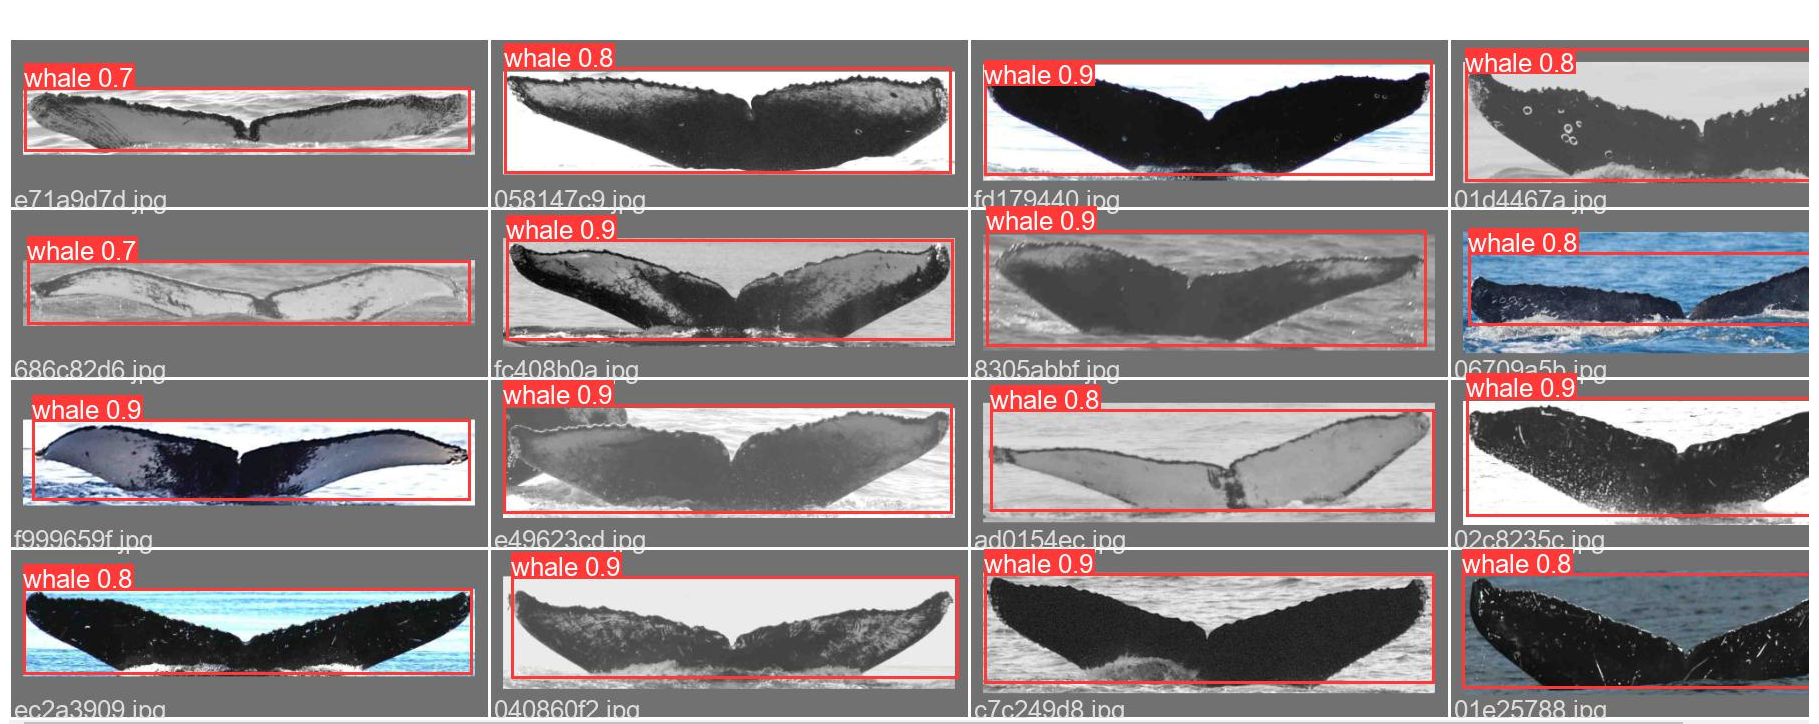

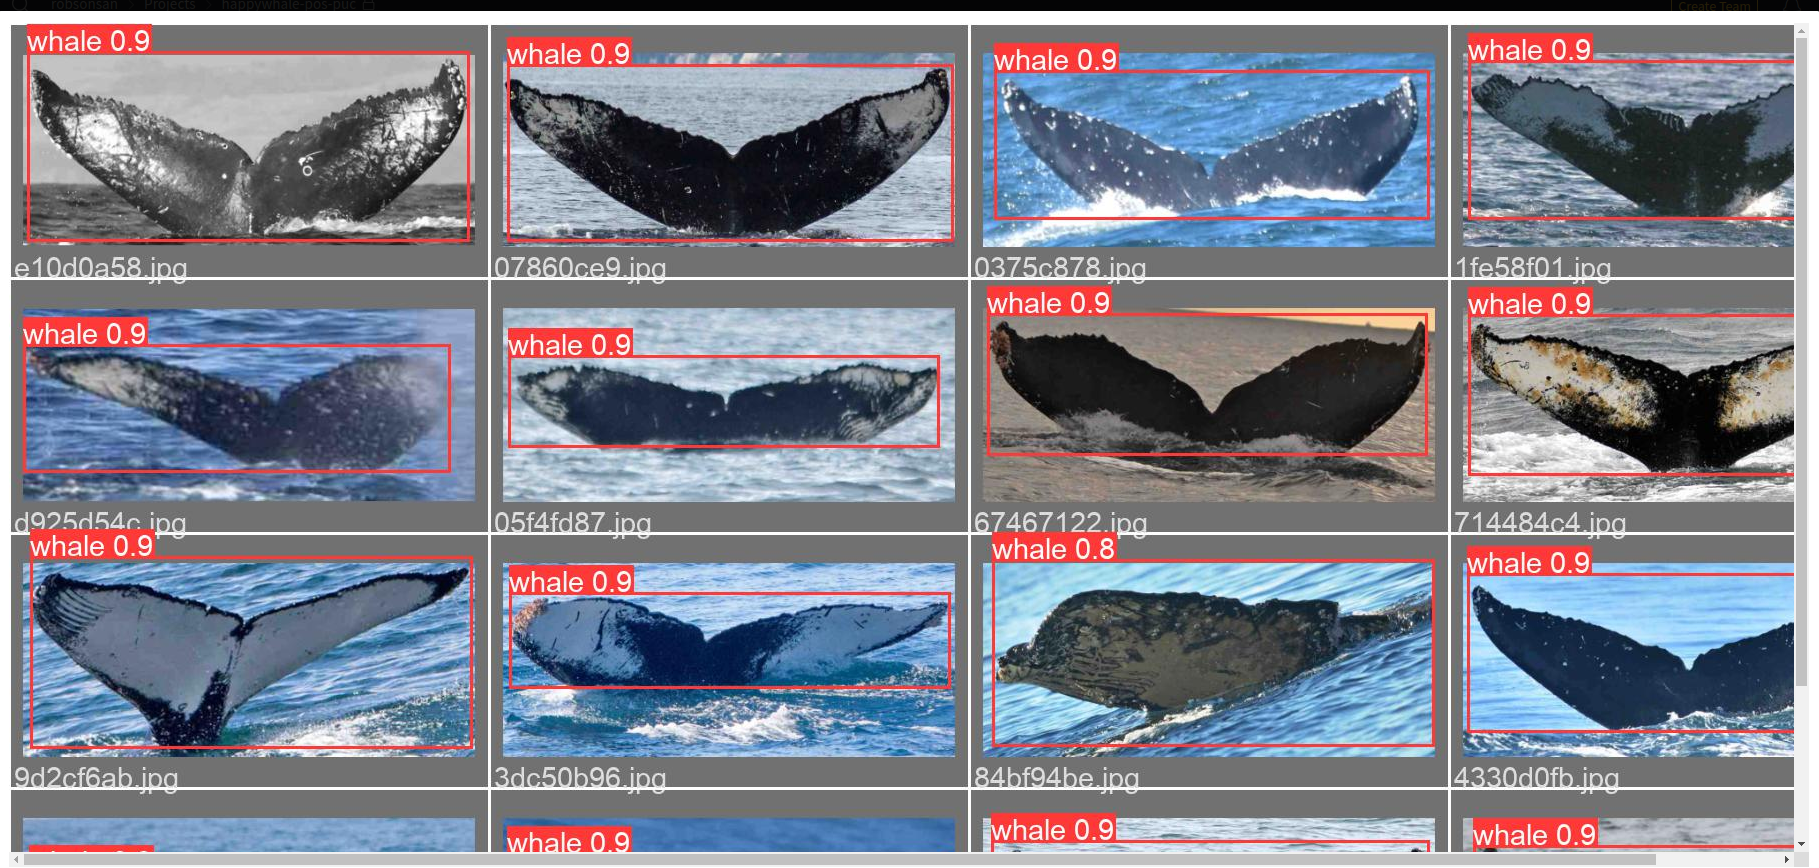

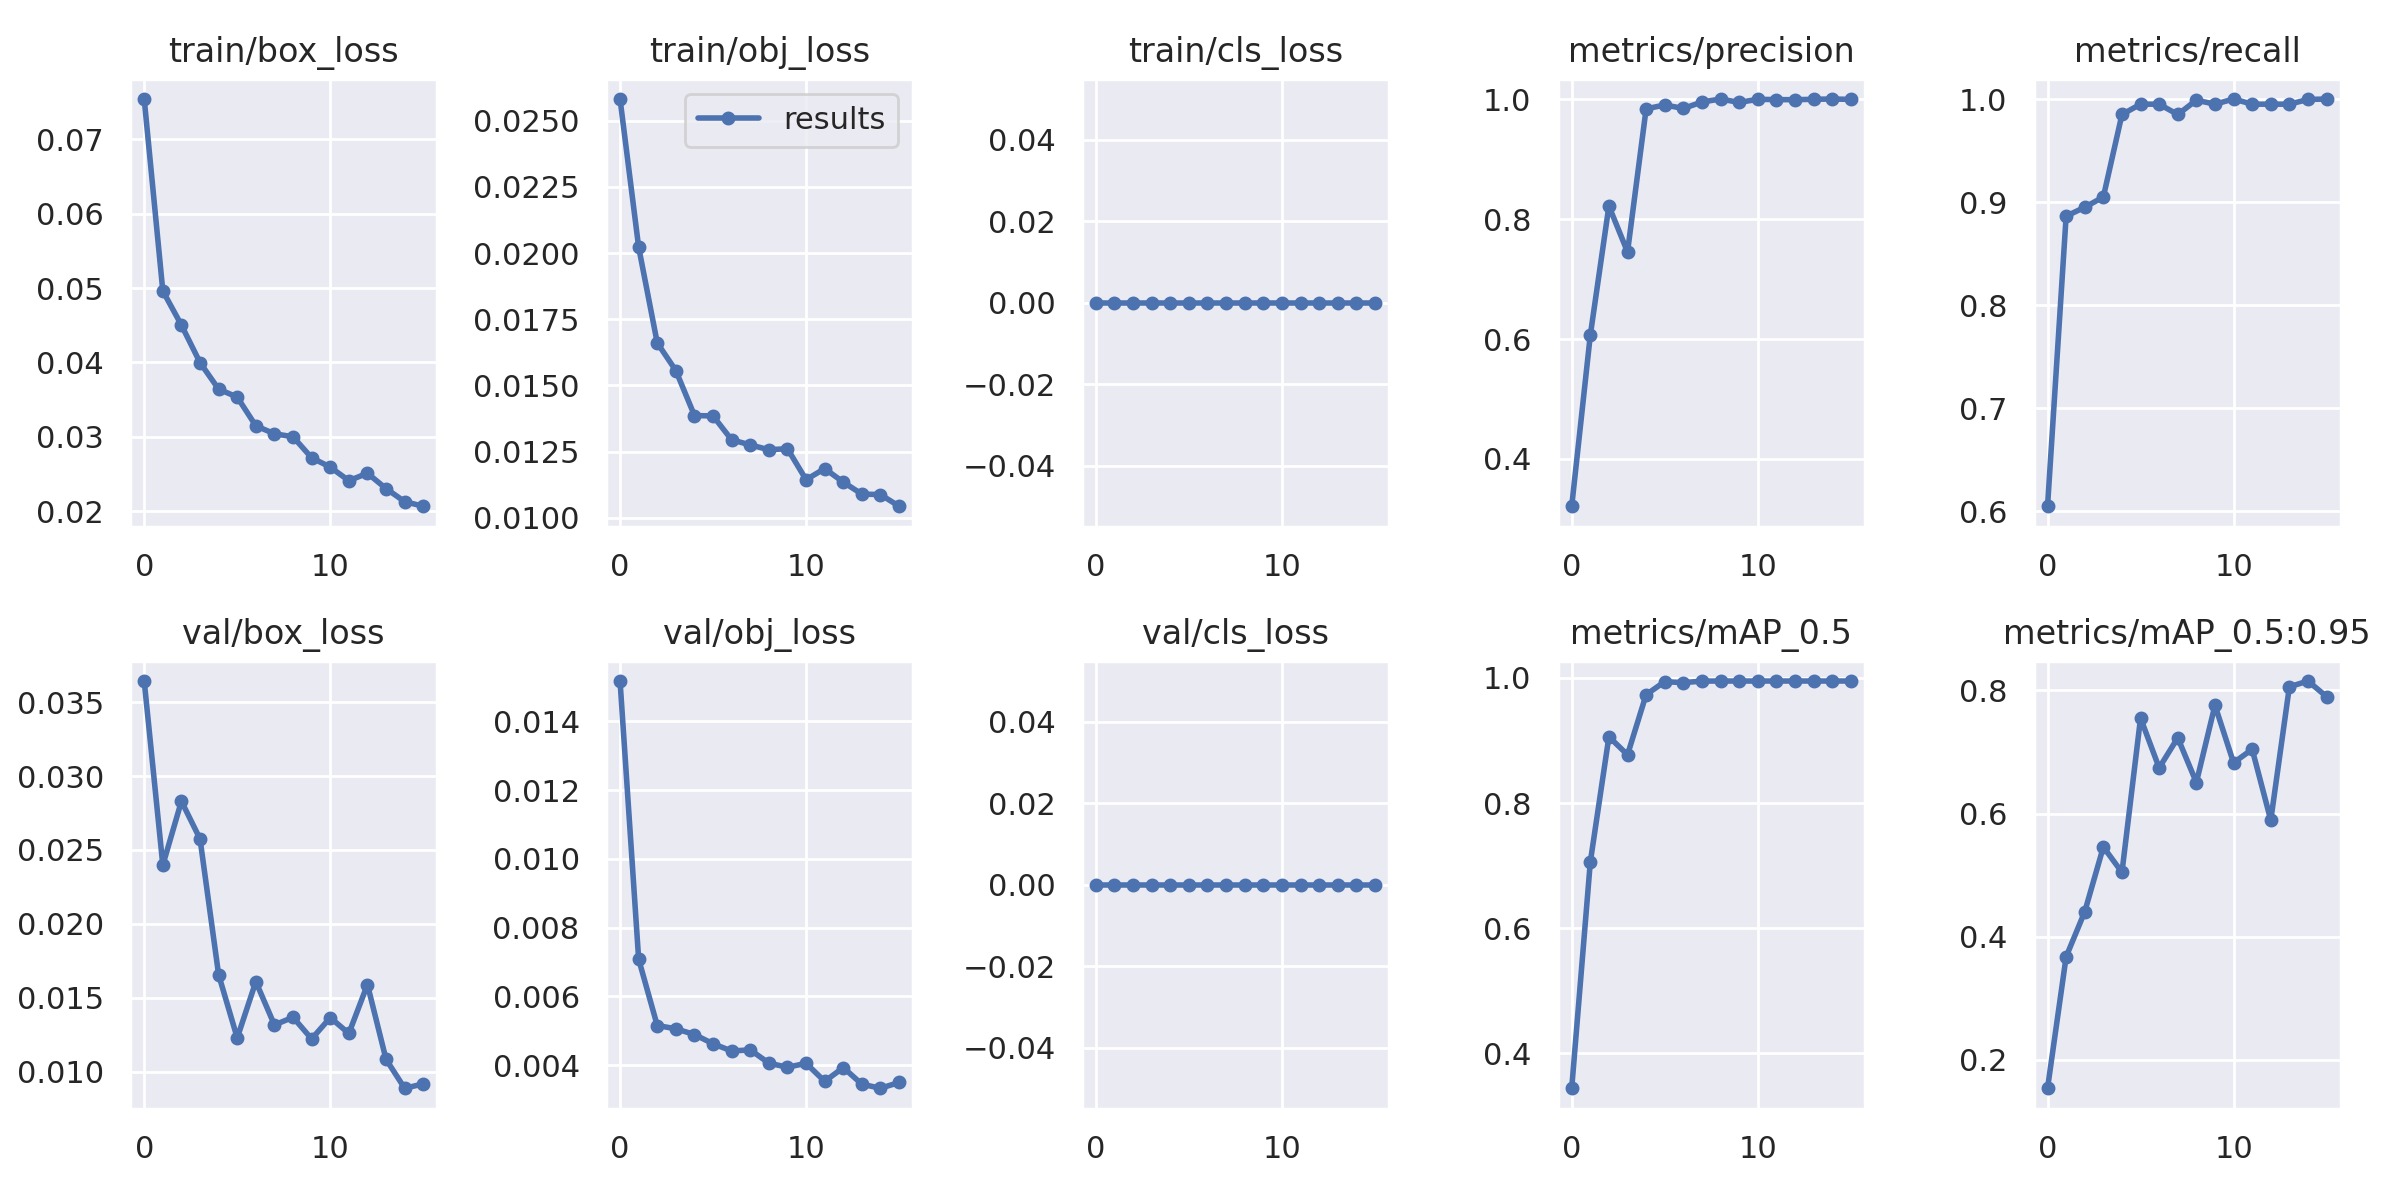

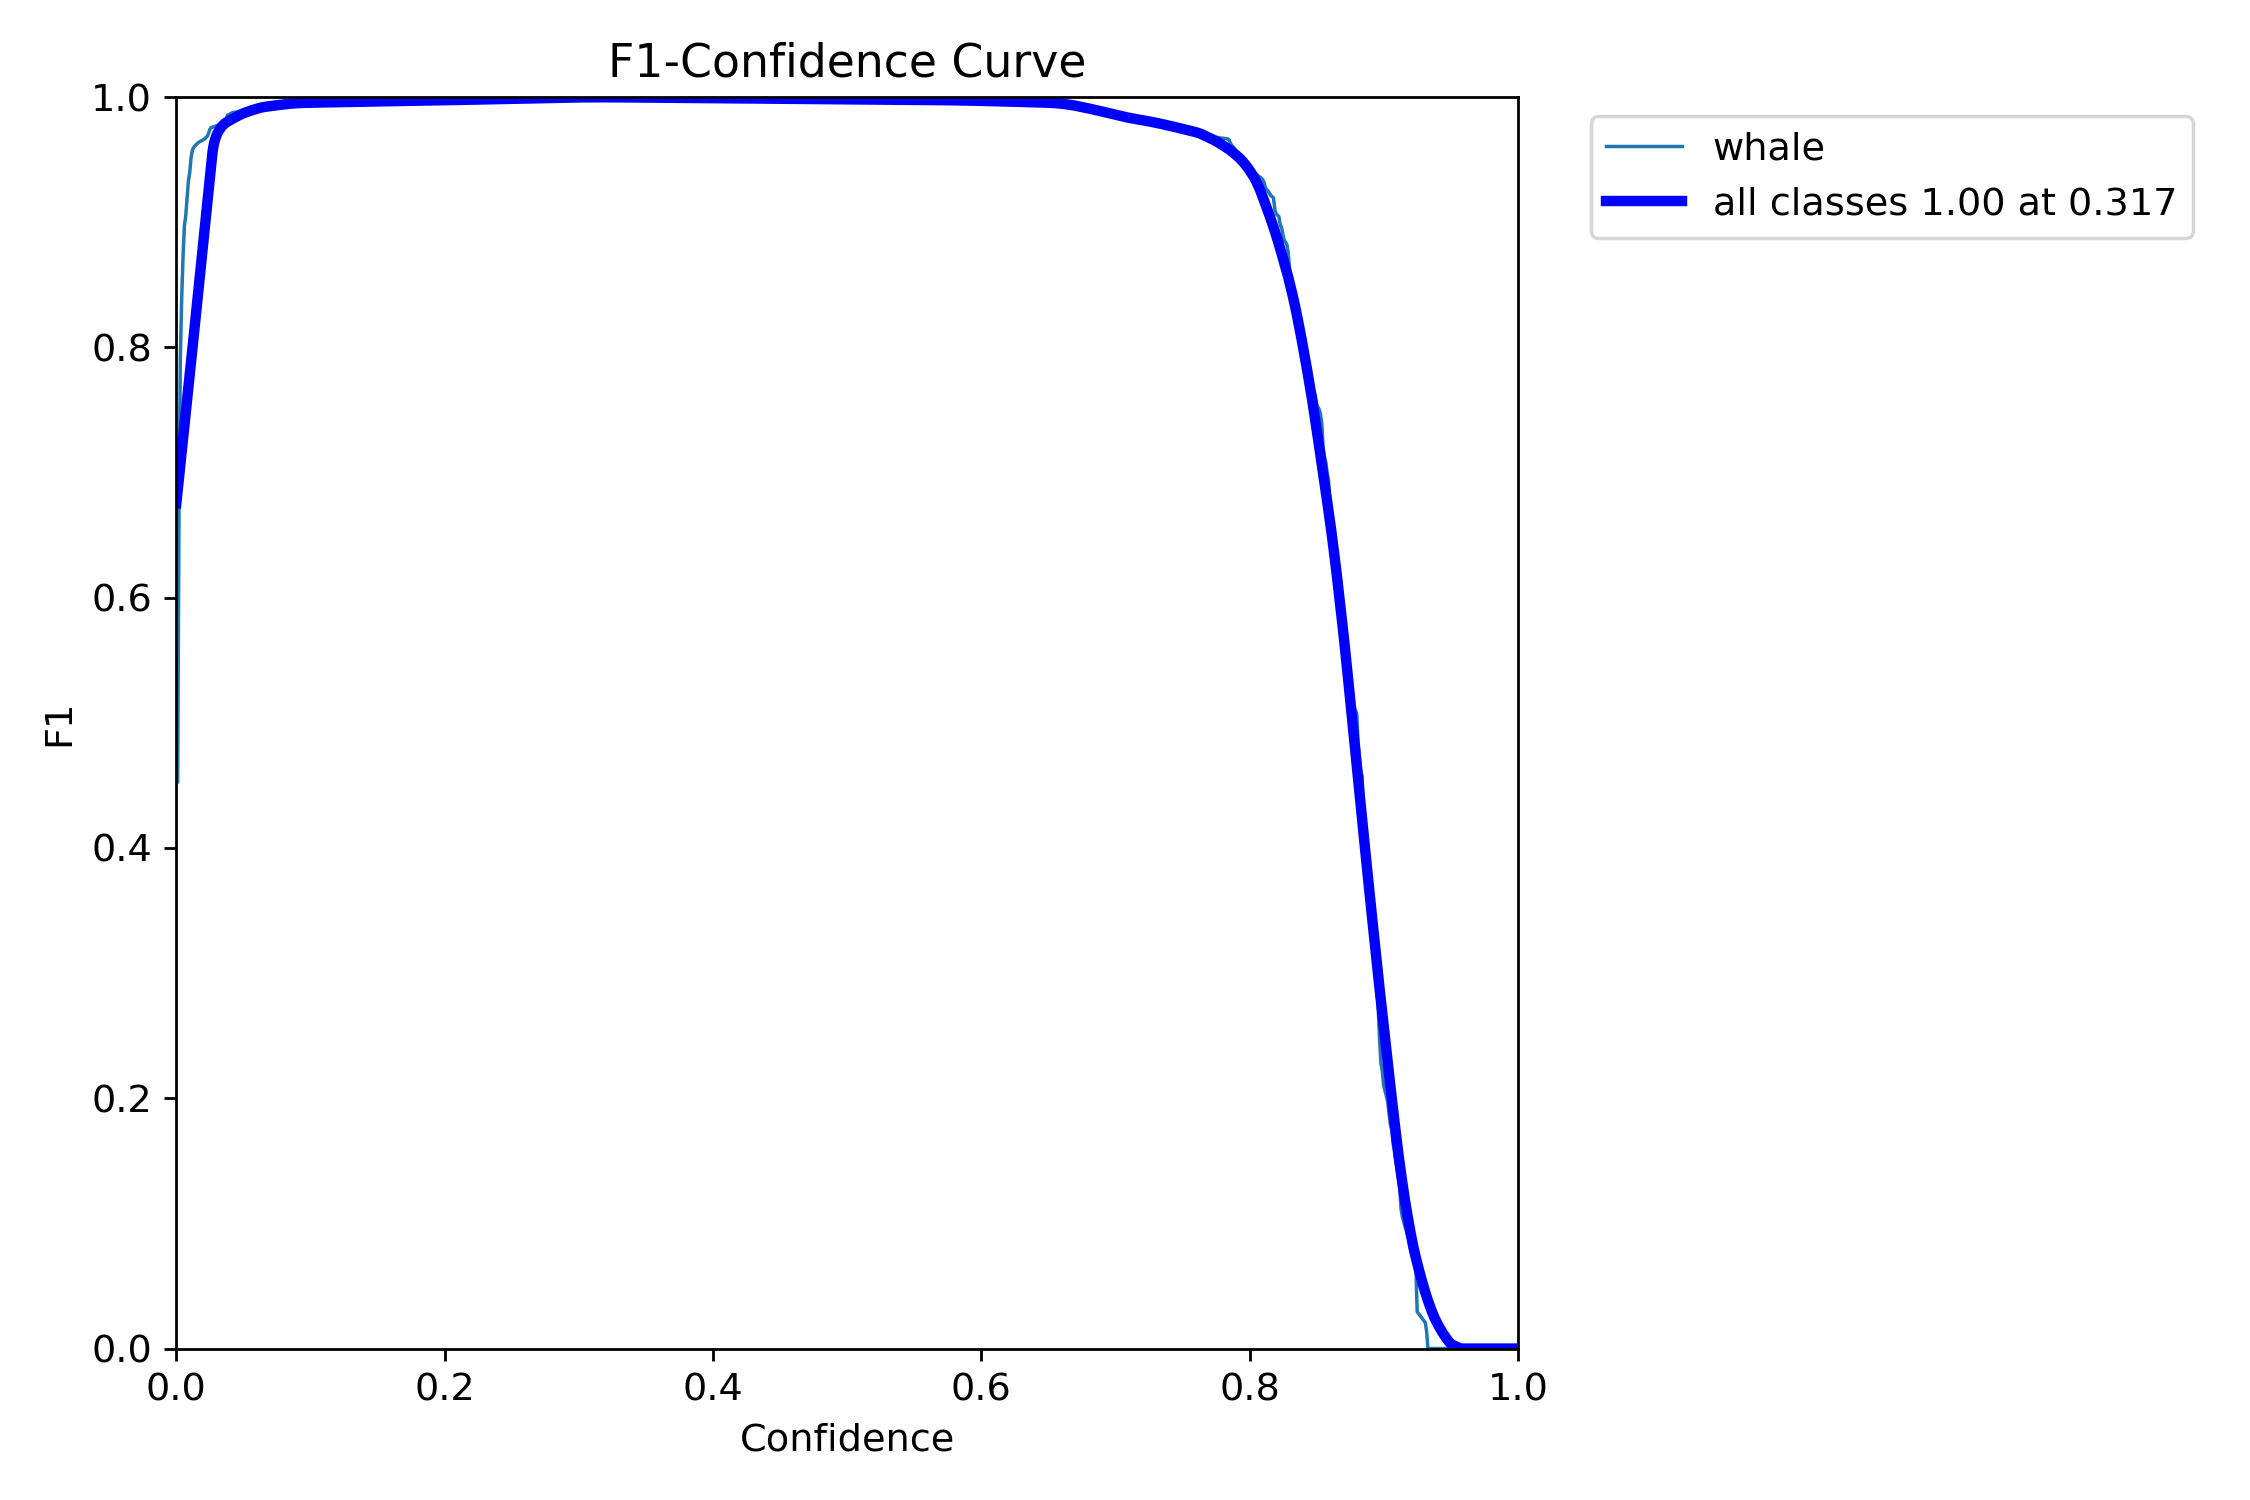